In [83]:
import tensorflow as tf

In [84]:
from tensorflow import keras

In [85]:
from tensorflow.keras import layers

In [86]:
import matplotlib.pyplot as plt

In [87]:
mnist = tf.keras.datasets.mnist

In [88]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [89]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

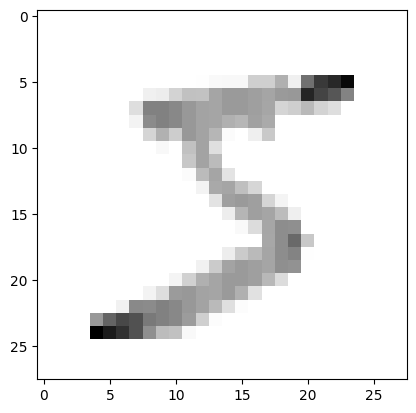

In [90]:
plt.imshow(X_train[0], cmap = plt.cm.binary)

In [91]:
#building the network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))


In [92]:
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [93]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9203 - loss: 0.2774
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9645 - loss: 0.1157
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9750 - loss: 0.0792
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9811 - loss: 0.0603
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9854 - loss: 0.0466
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9883 - loss: 0.0363
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9900 - loss: 0.0300
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9918 - loss: 0.0246
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9936 - loss: 0.0191
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9945 - loss: 0.0163
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9955 - loss: 0.0141
Epoch 12/100
1875/1

In [94]:
predictions = model.predict([X_test])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


/Users/Antony/Library/Python/3.12/lib/python/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_5
Received: inputs=('Tensor(shape=(32, 28, 28))',)
  warnings.warn(msg)
/Users/Antony/Library/Python/3.12/lib/python/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_5
Received: inputs=('Tensor(shape=(None, 28, 28))',)
  warnings.warn(msg)


In [95]:
import numpy as np

print(predictions[0])

[0.00000000e+00 0.00000000e+00 1.11426354e-35 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [96]:
print(y_test[0])

7


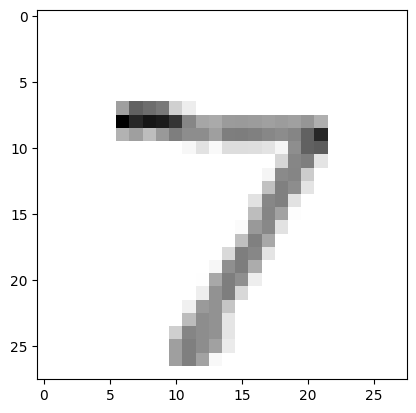

In [97]:
plt.imshow(X_test[0], cmap = plt.cm.binary)

In [98]:
print(predictions[52])
print(y_test[52])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2132224e-36]
5


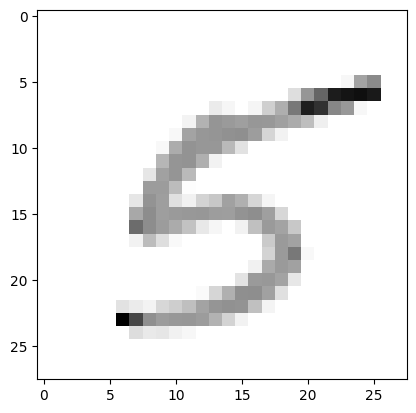

In [99]:
plt.imshow(X_test[52], cmap = plt.cm.binary)

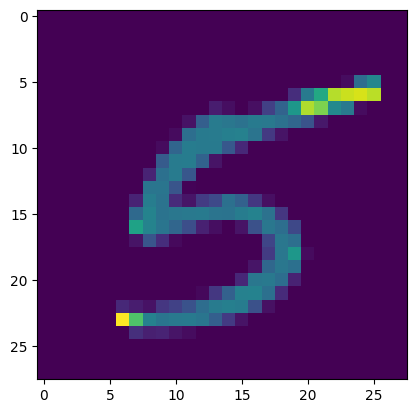

In [100]:
plt.imshow(X_test[52])

In [101]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.9756 - loss: 0.3632
Test accuracy: 0.9756


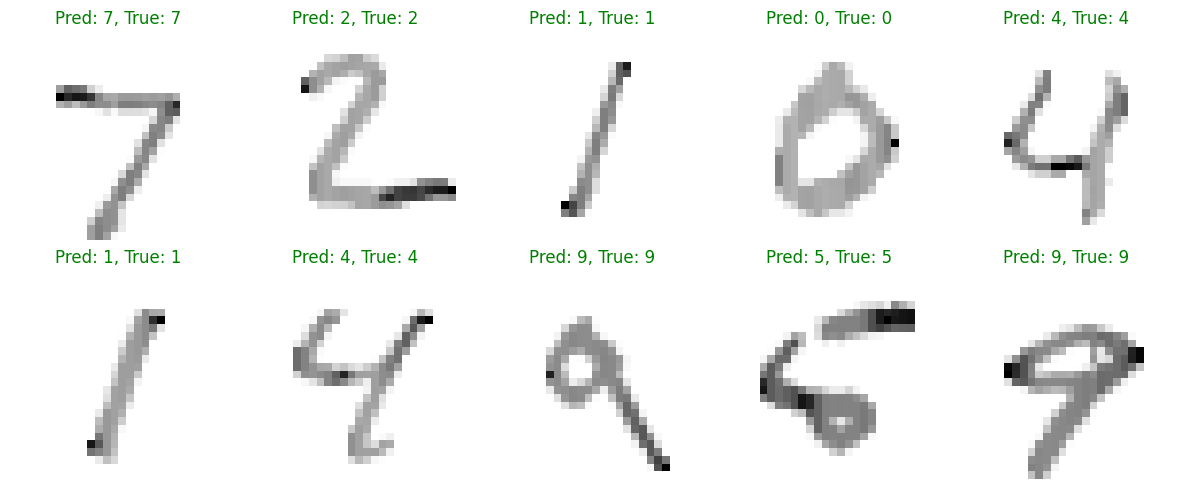

In [102]:
# Visualize some predictions
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i], cmap='binary')
    pred_label = np.argmax(predictions[i])
    true_label = y_test[i]
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f"Pred: {pred_label}, True: {true_label}", color=color)
    ax.axis('off')
plt.tight_layout()
plt.show()

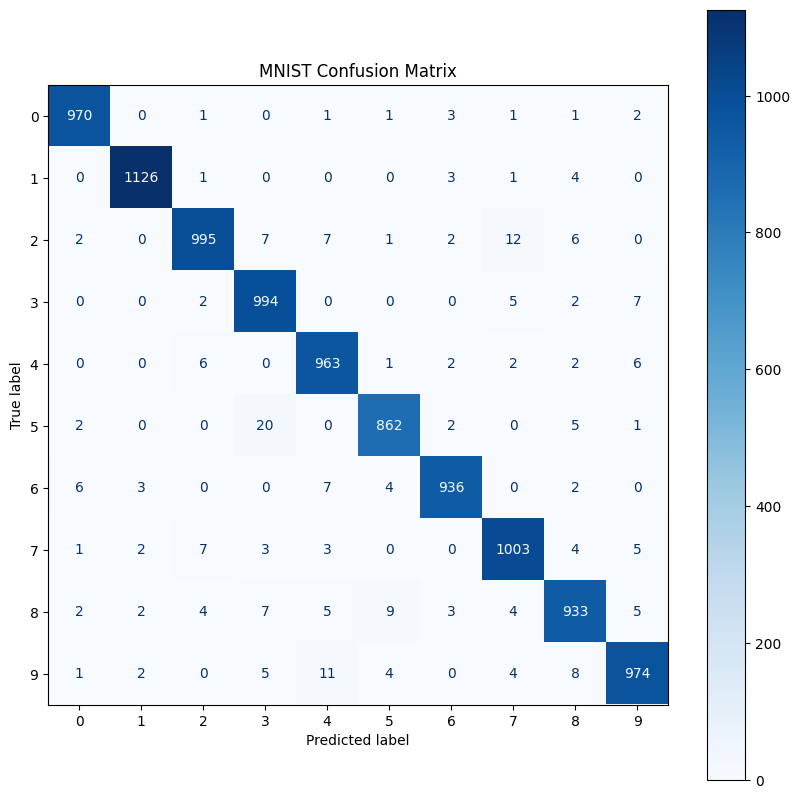

In [104]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', ax=ax)
plt.title('MNIST Confusion Matrix')
plt.show()

In [105]:
# Save the model
model.save('mnist_model.keras')
print("Model saved!")

Model saved!
